In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

import scipy.special

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.shape

(1338, 7)

In [4]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
le = LabelEncoder()
le.fit(data.sex.drop_duplicates())
data.sex = le.transform(data.sex) # male or female

le.fit(data.smoker.drop_duplicates())
data.smoker = le.transform(data.smoker) # smoker or not

le.fit(data.region.drop_duplicates())
data.region = le.transform(data.region)

In [6]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [7]:
data.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

<AxesSubplot:>

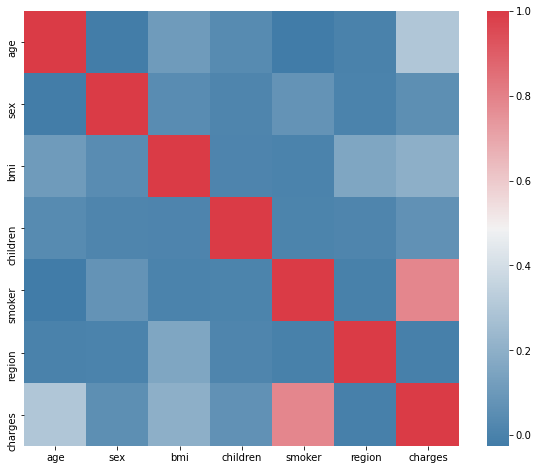

In [8]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(240, 10, as_cmap=True), 
            square=True, ax=ax)

In [9]:
p = figure(title='Distribution of charges', tools='save', background_fill_color='#E8DDCB')

hist, edges = np.histogram(data.charges)

p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color='#036564', line_color='#033649')

p.xaxis.axis_label = 'x'
p.yaxis.axis_label = 'Pr(x)'

output_notebook()
show(gridplot([p], ncols=2, plot_width=400, plot_height=400, toolbar_location=None))

Loading BokehJS ...

Text(0, 0.5, 'Count')

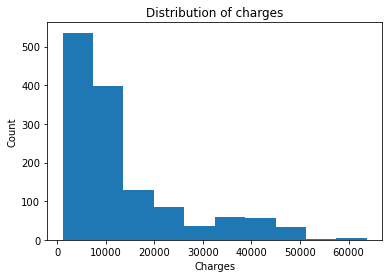

In [10]:
plt.hist(data.charges)
plt.title('Distribution of charges')
plt.xlabel('Charges')
plt.ylabel('Count')

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

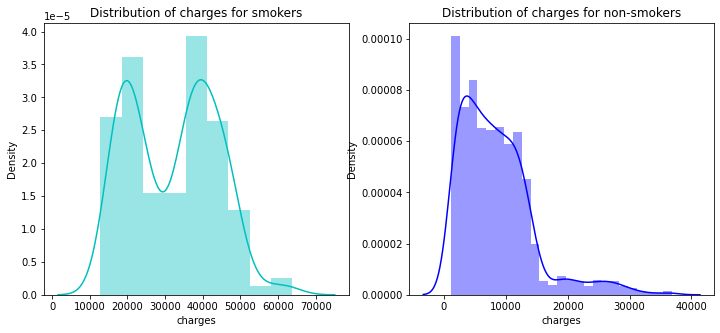

In [11]:
f = plt.figure(figsize=(12, 5))

ax = f.add_subplot(121)
sns.distplot(data[(data.smoker == 1)]['charges'], color='c', ax=ax)
ax.set_title('Distribution of charges for smokers')

ax = f.add_subplot(122)
sns.distplot(data[(data.smoker == 0)]['charges'], color='b', ax=ax)
ax.set_title('Distribution of charges for non-smokers')


In [12]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

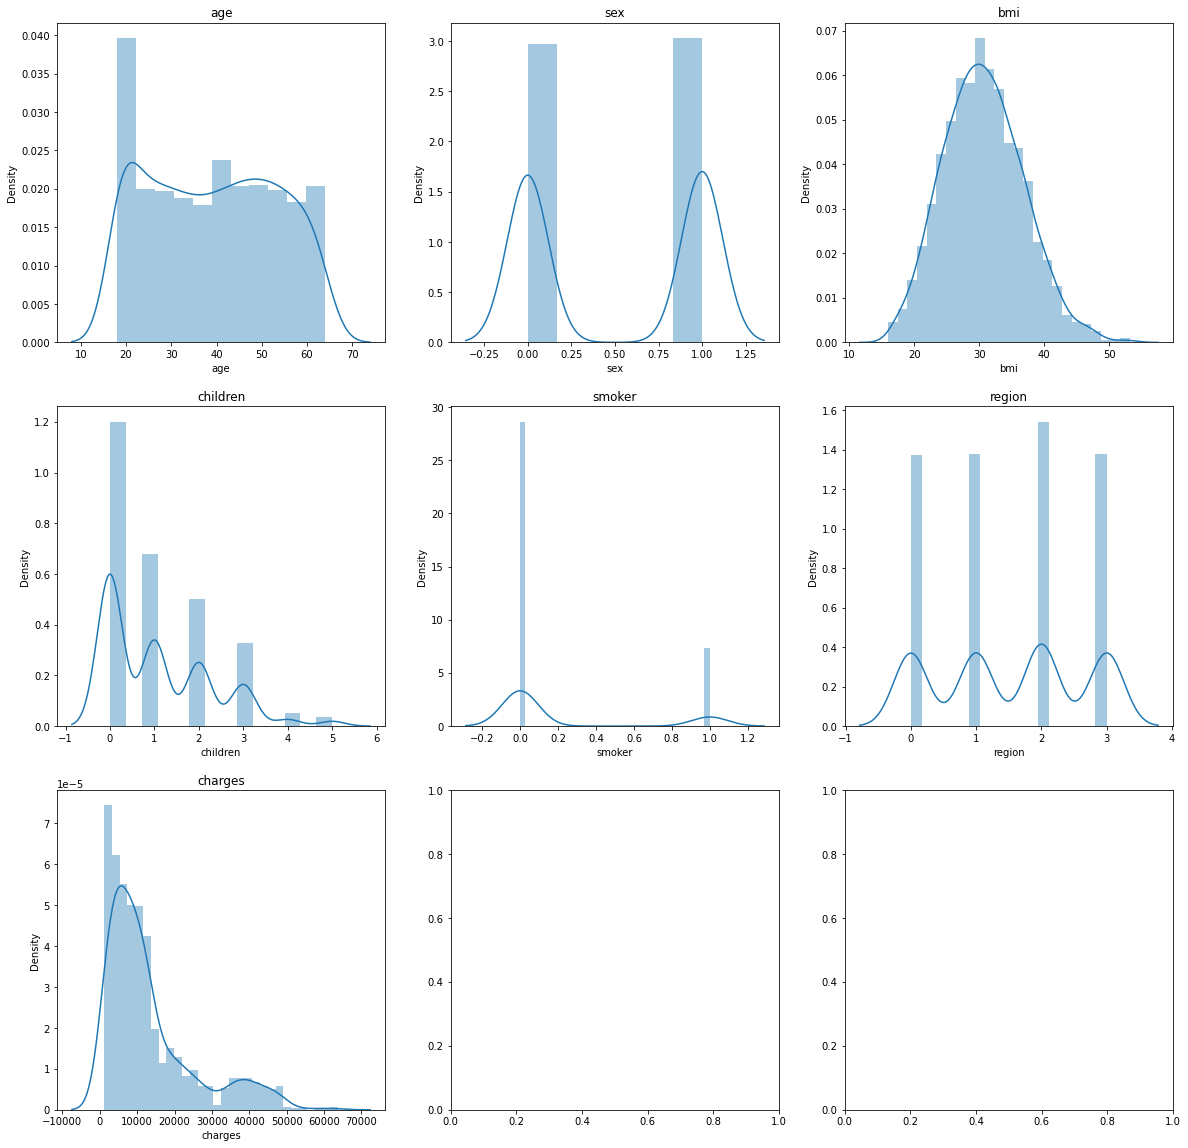

In [13]:
cols = data.columns
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for i, col in enumerate(cols):
    plt.subplot(3,3,i+1)
    sns.distplot(data[col])
    plt.title(col)
        

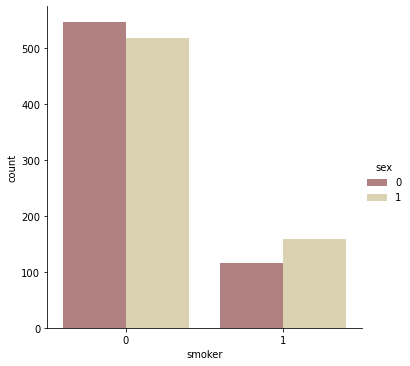

In [14]:
sns.catplot(x='smoker', kind='count', hue='sex', palette='pink', data=data)

In [15]:
smoker_sex = data.groupby(['smoker', 'sex']).size().unstack()
smoker_sex

sex,0,1
smoker,,
0,547,517
1,115,159


Text(0.5, 1.0, 'Count of smokers for each sex')

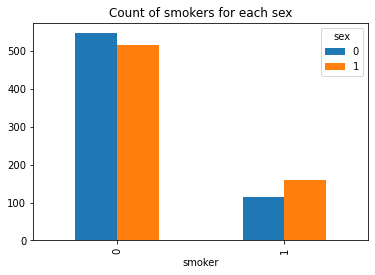

In [16]:
smoker_sex.plot(kind='bar')
plt.title('Count of smokers for each sex')

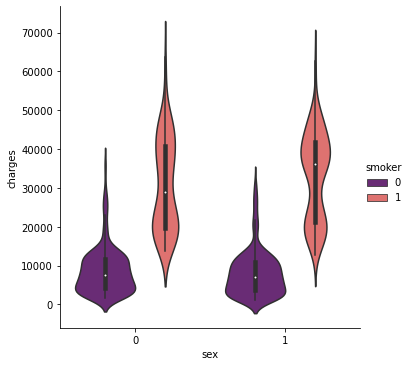

In [17]:
sns.catplot(x='sex', y='charges', hue='smoker', kind='violin', data=data, palette = 'magma')

In [18]:
smoker_sex_charges = data.groupby(['smoker', 'sex',])['charges'].mean().unstack()
smoker_sex_charges

sex,0,1
smoker,,
0,8762.297300,8087.204731
1,30678.996276,33042.005975


Text(0.5, 1.0, 'Mean charges for smokers in each sex')

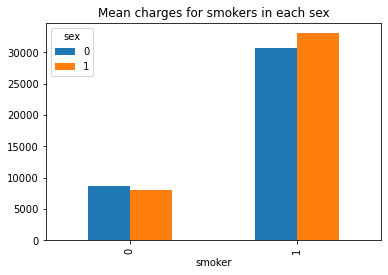

In [19]:
smoker_sex_charges.plot(kind='bar')
plt.title('Mean charges for smokers in each sex')

<AxesSubplot:title={'center':'Box plot for charges of men'}, xlabel='charges', ylabel='smoker'>

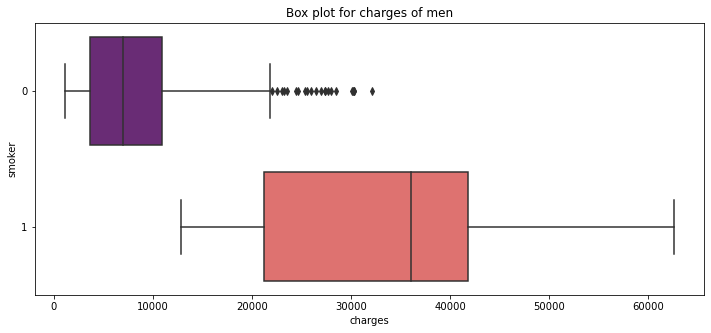

In [20]:
plt.figure(figsize=(12, 5))
plt.title('Box plot for charges of men')
sns.boxplot(y='smoker', x='charges', data=data[(data.sex == 1)], 
            orient='h', palette='magma')

<AxesSubplot:title={'center':'Box plot for charges for women'}, xlabel='charges', ylabel='smoker'>

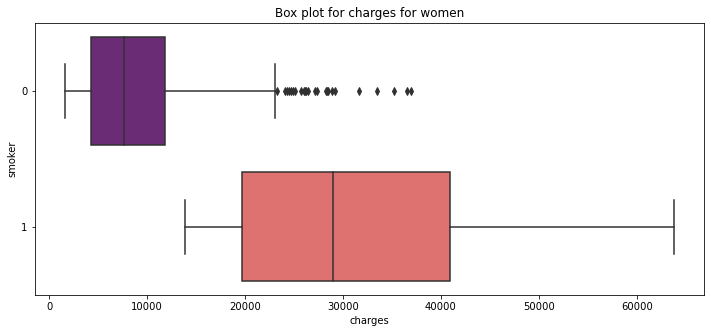

In [21]:
plt.figure(figsize=(12, 5))
plt.title('Box plot for charges for women')
sns.boxplot(x='charges', y='smoker', data=data[(data.sex == 0)], orient='h', palette='magma')

<AxesSubplot:title={'center':'Distribution of ages'}, xlabel='age', ylabel='Density'>

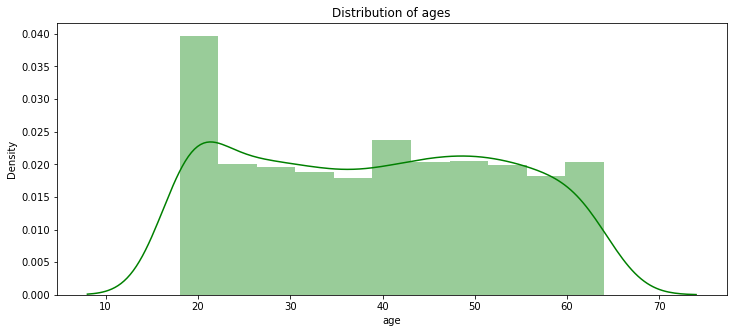

In [22]:
plt.figure(figsize=(12, 5))
plt.title('Distribution of ages')
sns.distplot(data['age'], color='g')

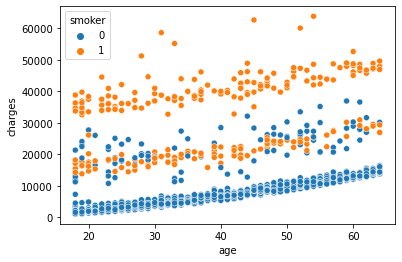

In [23]:
sns.scatterplot(x='age', y='charges', hue='smoker', data=data)
plt.show()

Text(0.5, 1.0, 'Distribution of charges and age for non-smokers')

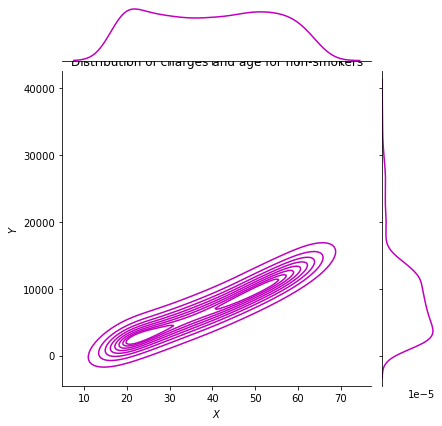

In [24]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 0)],kind="kde", color="m")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
plt.title('Distribution of charges and age for non-smokers')

Text(0.5, 1.0, 'Distribution of charges and age for smokers')

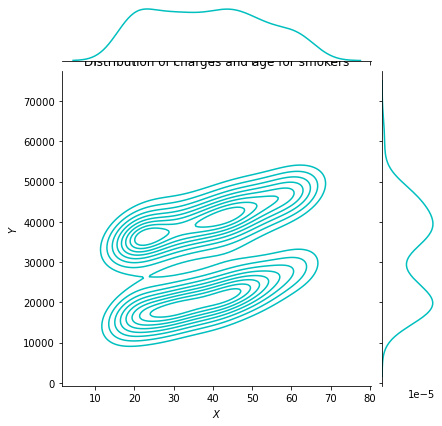

In [25]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 1)],kind="kde", color="c")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
plt.title('Distribution of charges and age for smokers')

Text(0.5, 1.0, 'Smokers and non-smokers')

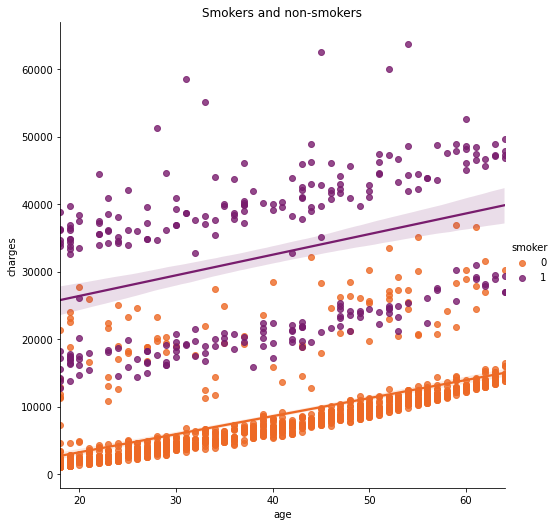

In [26]:
sns.lmplot(x="age", y="charges", hue="smoker", data=data, palette = 'inferno_r', size = 7)
plt.title('Smokers and non-smokers')

Text(0.5, 1.0, 'Distribution of bmi')

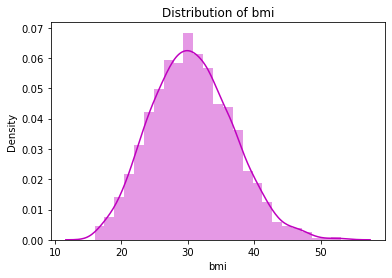

In [27]:
sns.distplot(data['bmi'], color='m')
plt.title('Distribution of bmi')

Text(0.5, 1.0, 'Distribution of charges for patients with BMI greater than 30')

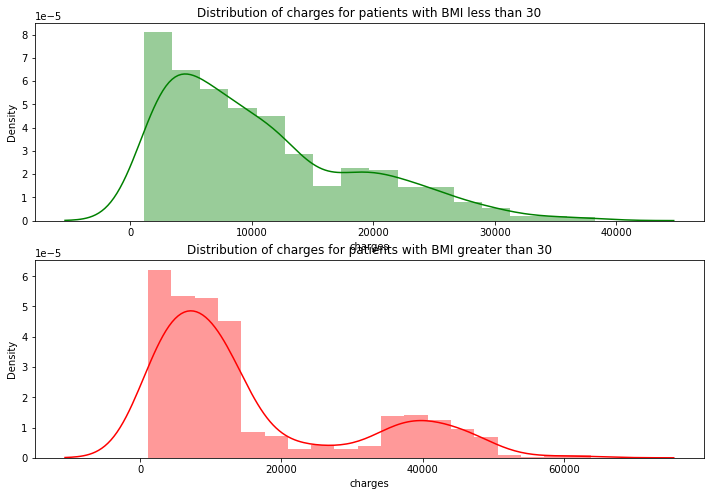

In [28]:
f = plt.figure(figsize=(12, 8))
f.add_subplot(211)
sns.distplot(data[(data['bmi'] <= 30)]['charges'], color='g')
plt.title('Distribution of charges for patients with BMI less than 30')

f.add_subplot(212)
sns.distplot(data[(data['bmi'] >= 30)]['charges'], color='r')
plt.title('Distribution of charges for patients with BMI greater than 30')


Text(0.5, 1.0, 'Distribution of charges on BMI greater and less than 30')

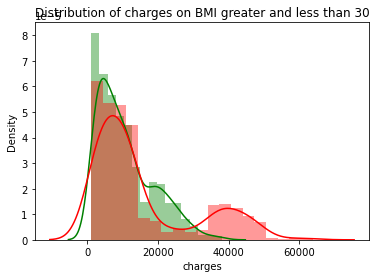

In [29]:
sns.distplot(data[(data['bmi'] <= 30)]['charges'], color='g')
sns.distplot(data[(data['bmi'] >= 30)]['charges'], color='r')
plt.title('Distribution of charges on BMI greater and less than 30')

Text(0.5, 1.0, 'Distribution of bmi and charges')

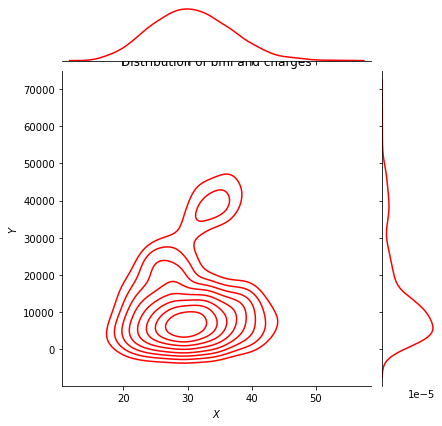

In [30]:
g = sns.jointplot(x="bmi", y="charges", data = data,kind="kde", color="r")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
plt.title('Distribution of bmi and charges')

<AxesSubplot:xlabel='bmi', ylabel='charges'>

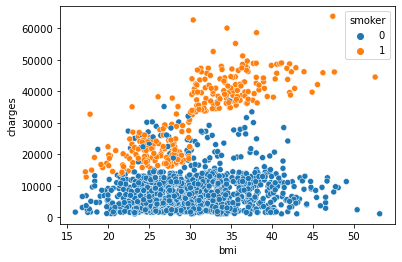

In [31]:
sns.scatterplot(x='bmi', y='charges', data=data, hue='smoker')

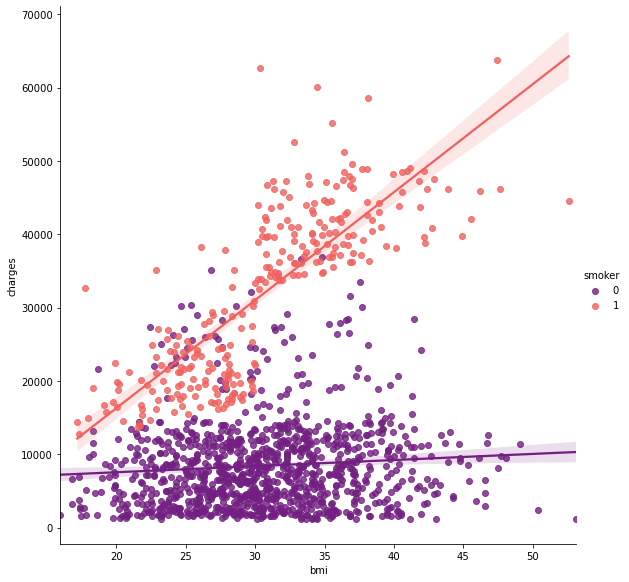

In [32]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=data, palette = 'magma', size = 8)

In [33]:
kids = data.groupby('children').size()
kids

children
0    574
1    324
2    240
3    157
4     25
5     18
dtype: int64

<AxesSubplot:xlabel='children'>

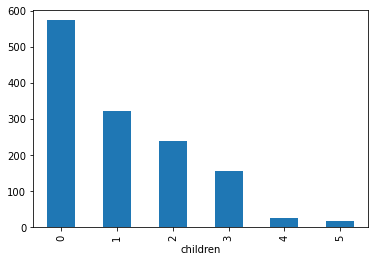

In [34]:
kids.plot(kind='bar')

Text(0.5, 1.0, 'Sex distribution of smokers and non-smokers who have children')

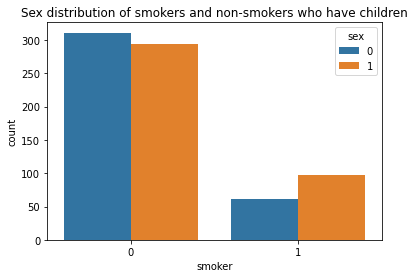

In [35]:
sns.countplot('smoker', data=data[(data.children > 0)], hue='sex')
plt.title('Sex distribution of smokers and non-smokers who have children')

# Time for Regression

In [36]:
x = data.drop(['charges'], axis=1)
y = data.charges

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
lr = LinearRegression().fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
x_test_pred = lr.predict(x_test)

print(lr.score(x_test, y_test))

0.7962732059725786


In [37]:
X = data.drop(['charges', 'region'], axis=1)
Y = data.charges

quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(x_quad, Y, random_state=0)

plr = LinearRegression().fit(X_train, Y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print(plr.score(X_test, Y_test))

0.884919734414724


In [38]:
forest = RandomForestRegressor(n_estimators=100,
                              criterion = 'friedman_mse',
                              random_state=1,
                              n_jobs=-1)
forest.fit(x_train, y_train)
forest_train_pred = forest.predict(x_train)
forest_test_pred = forest.predict(x_test)

print('MSE train data: %.3f, MSE test data: %.3f' % (mean_squared_error(y_train, forest_train_pred),
                                                     mean_squared_error(y_test, forest_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (r2_score(y_train, forest_train_pred), 
                                                   r2_score(y_test, forest_test_pred)))


MSE train data: 3746794.175, MSE test data: 20055026.186
R2 train data: 0.974, R2 test data: 0.873


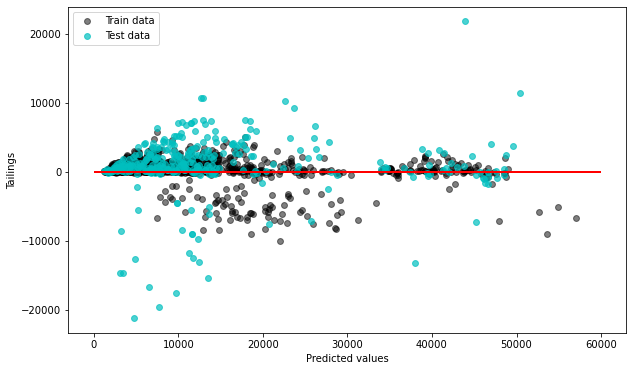

In [39]:
plt.figure(figsize=(10,6))

plt.scatter(forest_train_pred,forest_train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(forest_test_pred,forest_test_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Tailings')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
plt.show()